<a href="https://colab.research.google.com/github/manjitullal/unsupervised/blob/main/Kmean_Clustering_on_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
import pyspark

%matplotlib inline

print (pyspark.__version__)

3.0.1


In [ ]:
#https://rsandstroem.github.io/sparkkmeans.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/datasets/movies/movie_data_merge.rar'

/content/drive/MyDrive/datasets/movies/movie_data_merge.rar


In [ ]:
!unrar x '/content/drive/MyDrive/datasets/movies/movie_data_merge.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/datasets/movies/movie_data_merge.rar

Extracting  movie_data_merge                                               0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 

In [52]:
data = pd.read_pickle('/content/movie_data_merge')
data.head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew,score
314,False,25000000,"Drama, Crime",278.0,tt0111161,en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,51.6454,"Castle Rock Entertainment, Warner Bros",United States of America,1994-09-23,2.834147e+07,142.0,English,Released,The Shawshank Redemption,8.5,8358.0,"[{'cast_id': 3, 'character': 'Andy Dufresne', ...","[{'credit_id': '52fe4231c3a36847f800b127', 'de...",8.445870
837,False,6000000,"Drama, Crime",238.0,tt0068646,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",41.1093,"Paramount Pictures, Alfran Productions",United States of America,1972-03-14,2.450664e+08,175.0,"English, Italiano, Latin",Released,The Godfather,8.5,6024.0,"[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093db', 'de...",8.425439
10345,False,13200000,"Comedy, Drama, Romance",19404.0,tt0112870,hi,Dilwale Dulhania Le Jayenge,"Raj is a rich, carefree, happy-go-lucky second...",34.457,Yash Raj Films,India,1995-10-20,1.000000e+08,190.0,हिन,Released,Dilwale Dulhania Le Jayenge,9.1,661.0,"[{'cast_id': 1, 'character': 'Raj Malhotra', '...","[{'credit_id': '57a3054a9251417c57000d7a', 'de...",8.421458
12525,False,185000000,"Drama, Action, Crime, Thriller",155.0,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167,"DC Comics, Legendary Pictures, Warner Bros, D...","United Kingdom, United States of America",2008-07-16,1.004558e+09,152.0,"English, 普通话",Released,The Dark Knight,8.3,12269.0,"[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",8.265477
2854,False,63000000,Drama,550.0,tt0137523,en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,63.8696,"Twentieth Century Fox Film Corporation, Regen...","Germany, United States of America",1999-10-15,1.008538e+08,139.0,English,Released,Fight Club,8.3,9678.0,"[{'cast_id': 4, 'character': 'The Narrator', '...","[{'credit_id': '55731b8192514111610027d7', 'de...",8.256385


In [ ]:
df.shape

(45538, 22)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.adult= le.fit_transform(df.adult.values)

In [ ]:
# all_genres = df["genres"].str.split(",",expand = True) 
# new_df = pd.concat([df, all_genres],axis=1)
# new_df = new_df.rename(columns={0:'genre1', 1:'genre2', 2:'genre3', 3:'genre4',
#                                4:'genre5', 5:'genre6', 6:'genre7', 7:'genre8'})
# new_df.drop(['genres'], axis=1, inplace=True)
# new_df.genre1= le.fit_transform(new_df.genre1.astype(str).values)
# new_df.genre2= le.fit_transform(new_df.genre2.astype(str).values)
# new_df.genre3= le.fit_transform(new_df.genre3.astype(str).values)
# new_df.genre4= le.fit_transform(new_df.genre4.astype(str).values)
# new_df.genre5= le.fit_transform(new_df.genre5.astype(str).values)
# new_df.genre6= le.fit_transform(new_df.genre6.astype(str).values)
# new_df.genre7= le.fit_transform(new_df.genre7.astype(str).values)
# new_df.genre8= le.fit_transform(new_df.genre8.astype(str).values)

In [ ]:
df.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'title', 'vote_average', 'vote_count',
       'cast', 'crew', 'score'],
      dtype='object')

In [ ]:
FEATURES_COL = ['id','adult', 'budget', 'popularity', 'revenue', 'vote_average', 'vote_count', 'score']

In [ ]:
df = data[FEATURES_COL]
df.head()

,id,adult,budget,popularity,revenue,vote_average,vote_count,score
314,278.0,0,25000000,51.6454,2.834147e+07,8.5,8358.0,8.445870
837,238.0,0,6000000,41.1093,2.450664e+08,8.5,6024.0,8.425439
10345,19404.0,0,13200000,34.457,1.000000e+08,9.1,661.0,8.421458
12525,155.0,0,185000000,123.167,1.004558e+09,8.3,12269.0,8.265477
2854,550.0,0,63000000,63.8696,1.008538e+08,8.3,9678.0,8.256385


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# data_scaled = scaler.fit_transform(df)
# df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
# df_scaled.head()
df.to_csv(r'/content/data.csv', index=False)

In [ ]:
df_spark = spark.read.csv('/content/data.csv', header=True) # requires spark 2.0
df_spark.show()

+--------+-----+---------+------------------+------------+------------+----------+-----------------+
|      id|adult|   budget|        popularity|     revenue|vote_average|vote_count|            score|
+--------+-----+---------+------------------+------------+------------+----------+-----------------+
|   278.0|    0| 25000000|         51.645403|  28341469.0|         8.5|    8358.0|8.445869586835052|
|   238.0|    0|  6000000|         41.109264| 245066411.0|         8.5|    6024.0| 8.42543938238373|
| 19404.0|    0| 13200000|         34.457024| 100000000.0|         9.1|     661.0|8.421458149404364|
|   155.0|    0|185000000|        123.167259|1004558444.0|         8.3|   12269.0|8.265477282215866|
|   550.0|    0| 63000000|         63.869599| 100853753.0|         8.3|    9678.0| 8.25638515355367|
|   680.0|    0|  8000000|140.95023600000002| 213928762.0|         8.3|    8670.0|8.251406244695469|
|   424.0|    0| 22000000|41.725122999999996| 321365567.0|         8.3|    4436.0|8.2066399

In [ ]:
for col in df_spark.columns:
    if col in FEATURES_COL:
        df_spark = df_spark.withColumn(col,df_spark[col].cast('float'))

In [ ]:
df_spark = df_spark.na.drop()

In [ ]:
FEATURES_COL = ['adult', 'budget', 'popularity', 'revenue', 'vote_average', 'vote_count', 'score']

In [ ]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df_spark).select('id', 'features')
df_kmeans.show()

+--------+--------------------+
|      id|            features|
+--------+--------------------+
|   278.0|[278.0,0.0,2.5E7,...|
|   238.0|[238.0,0.0,600000...|
| 19404.0|[19404.0,0.0,1.32...|
|   155.0|[155.0,0.0,1.85E8...|
|   550.0|[550.0,0.0,6.3E7,...|
|   680.0|[680.0,0.0,800000...|
|   424.0|[424.0,0.0,2.2E7,...|
|244786.0|[244786.0,0.0,330...|
|   129.0|[129.0,0.0,1.5E7,...|
|   637.0|[637.0,0.0,2.0E7,...|
|   240.0|[240.0,0.0,1.3E7,...|
|   510.0|[510.0,0.0,300000...|
|    13.0|[13.0,0.0,5.5E7,4...|
|  1891.0|[1891.0,0.0,1.8E7...|
|   539.0|[539.0,0.0,806948...|
| 77338.0|[77338.0,0.0,1.3E...|
|372058.0|[372058.0,0.0,0.0...|
|   101.0|[101.0,0.0,1.6E7,...|
|   497.0|[497.0,0.0,6.0E7,...|
|   769.0|[769.0,0.0,2.5E7,...|
+--------+--------------------+
only showing top 20 rows



In [ ]:
cost = np.zeros(30)
evaluator = ClusteringEvaluator()
for k in range(2,30):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    predictions = model.transform(df_kmeans)    
    cost[k] = evaluator.evaluate(predictions)

Text(0, 0.5, 'cost')

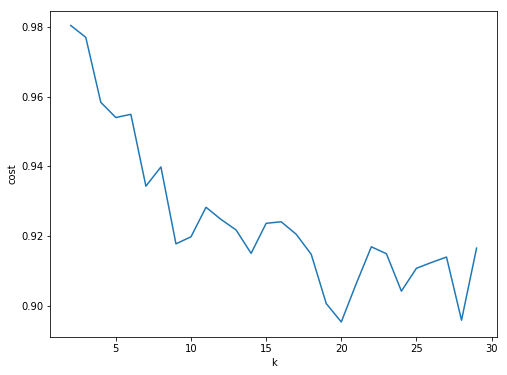

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,30),cost[2:30])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [31]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.13551117e+05 2.17113357e-04 5.05882938e+05 2.09986944e+00
 5.28679112e+05 5.55718043e+00 3.10545437e+01 5.68709793e+00]
[9.73170816e+04 0.00000000e+00 1.80265306e+08 4.93718943e+01
 1.05388541e+09 7.00612248e+00 5.62663265e+03 6.96640029e+00]
[7.30302292e+04 0.00000000e+00 1.38571354e+08 3.10240837e+01
 6.85835267e+08 6.85937500e+00 4.59177083e+03 6.81409525e+00]
[5.52031865e+04 0.00000000e+00 9.68000000e+07 1.39505538e+01
 2.79261987e+08 6.31088082e+00 1.88470466e+03 6.24427151e+00]
[5.56768567e+04 0.00000000e+00 4.66130545e+07 1.41875896e+01
 2.04300560e+08 6.46751591e+00 1.45029936e+03 6.36553732e+00]
[5.37330000e+04 0.00000000e+00 2.27333333e+08 8.11953252e+01
 2.23374101e+09 7.39999994e+00 9.29233333e+03 7.36816120e+00]
[5.77862989e+04 0.00000000e+00 9.63914130e+07 1.80736829e+01
 4.17155742e+08 6.64619565e+00 2.87770109e+03 6.58351564e+00]
[5.43006009e+04 0.00000000e+00 4.67336054e+07 1.10472976e+01
 1.19007879e+08 6.33462089e+00 9.35981402e+02 6.20725922e+00

In [32]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id=278.0, prediction=8), Row(id=238.0, prediction=4), Row(id=19404.0, prediction=7)]


In [34]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+--------+----------+
|      id|prediction|
+--------+----------+
|   278.0|         8|
|   238.0|         4|
| 19404.0|         7|
|   155.0|         1|
|   550.0|         7|
|   680.0|         4|
|   424.0|         3|
|244786.0|         0|
|   129.0|         4|
|   637.0|         4|
|   240.0|         9|
|   510.0|         7|
|    13.0|         2|
|  1891.0|         6|
|   539.0|         9|
| 77338.0|         6|
|372058.0|         6|
|   101.0|         9|
|   497.0|         3|
|   769.0|         9|
+--------+----------+
only showing top 20 rows



In [35]:
df_pred = df_pred.join(df_spark, 'id')
df_pred.show()

+--------+----------+-----+---------+----------+------------+------------+----------+--------+
|      id|prediction|adult|   budget|popularity|     revenue|vote_average|vote_count|   score|
+--------+----------+-----+---------+----------+------------+------------+----------+--------+
|   278.0|         8|  0.0|    2.5E7| 51.645405| 2.8341468E7|         8.5|    8358.0|8.445869|
|   238.0|         4|  0.0|6000000.0| 41.109264|2.45066416E8|         8.5|    6024.0| 8.42544|
| 19404.0|         7|  0.0|   1.32E7| 34.457024|       1.0E8|         9.1|     661.0|8.421458|
|   155.0|         1|  0.0|   1.85E8| 123.16726|1.00455846E9|         8.3|   12269.0|8.265477|
|   550.0|         7|  0.0|    6.3E7|   63.8696|1.00853752E8|         8.3|    9678.0|8.256385|
|   680.0|         4|  0.0|8000000.0| 140.95024|2.13928768E8|         8.3|    8670.0|8.251407|
|   424.0|         3|  0.0|    2.2E7| 41.725124|3.21365568E8|         8.3|    4436.0| 8.20664|
|244786.0|         0|  0.0|3300000.0|  64.29999|  

In [36]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,adult,budget,popularity,revenue,vote_average,vote_count,score
id,,,,,,,,
278.0,8,0.0,25000000.0,51.645405,2.834147e+07,8.5,8358.0,8.445869
238.0,4,0.0,6000000.0,41.109264,2.450664e+08,8.5,6024.0,8.425440
19404.0,7,0.0,13200000.0,34.457024,1.000000e+08,9.1,661.0,8.421458
155.0,1,0.0,185000000.0,123.167259,1.004558e+09,8.3,12269.0,8.265477
550.0,7,0.0,63000000.0,63.869598,1.008538e+08,8.3,9678.0,8.256385


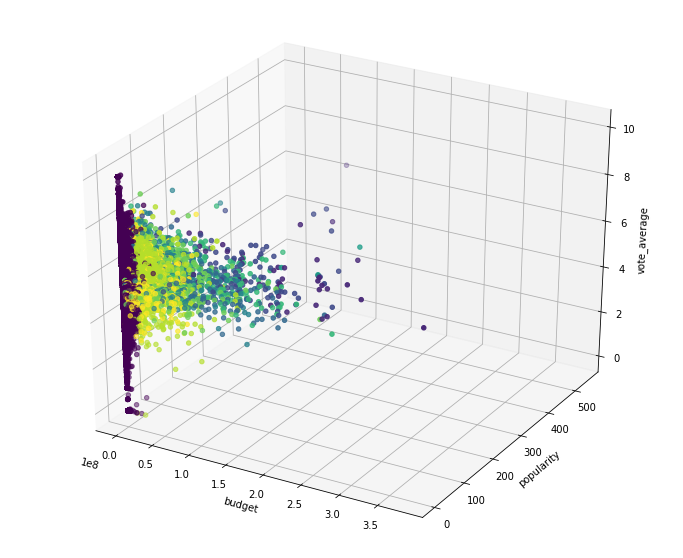

In [39]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.budget, pddf_pred.popularity, pddf_pred.vote_average, c=pddf_pred.prediction)
threedee.set_xlabel('budget')
threedee.set_ylabel('popularity')
threedee.set_zlabel('vote_average')
plt.show()

In [46]:
predicted_similar = pddf_pred[pddf_pred.prediction == 8].index

In [53]:
data[data.index.isin(predicted_similar)].head()

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,cast,crew,score
522,False,22000000,"Drama, History, War",424.0,tt0108052,en,Schindler's List,The true story of how businessman Oskar Schind...,41.7251,"Universal Pictures, Amblin Entertainment",United States of America,1993-11-29,3.213656e+08,195.0,"Deutsch, Polski, עִב, English",Released,Schindler's List,8.3,4436.0,"[{'cast_id': 14, 'character': 'Oskar Schindler...","[{'credit_id': '52fe4241c3a36847f801024d', 'de...",8.206640
1245,False,2000000,Comedy,914.0,tt0032553,en,The Great Dictator,Dictator Adenoid Hynkel tries to expand his em...,9.24175,"United Artists, Roy Export Company Establishment",United States of America,1940-10-15,1.100000e+07,125.0,"English, Esperanto",Released,The Great Dictator,8.1,756.0,"[{'cast_id': 13, 'character': 'Hynkel - Dictat...","[{'credit_id': '52fe428cc3a36847f8027429', 'de...",7.666503
10878,False,54000000,"Action, Thriller, Fantasy",752.0,tt0434409,en,V for Vendetta,In a world in which Great Britain has become a...,20.2144,"Studio Babelsberg, DC Comics, Virtual Studios...","Germany, United Kingdom, United States of Ame...",2006-03-15,1.325110e+08,132.0,English,Released,V for Vendetta,7.7,4562.0,"[{'cast_id': 23, 'character': 'Evey Hammond', ...","[{'credit_id': '52fe4270c3a36847f801ebf5', 'de...",7.629461
1909,False,92620000,Drama,19.0,tt0017136,de,Metropolis,In a futuristic city sharply divided between t...,14.4879,"Paramount Pictures, Universum Film",Germany,1927-01-10,6.504220e+05,153.0,No Language,Released,Metropolis,8.0,666.0,"[{'cast_id': 10, 'character': 'Maria', 'credit...","[{'credit_id': '52fe420fc3a36847f8000c55', 'de...",7.538641
15413,False,200000000,"Animation, Family, Comedy",10193.0,tt0435761,en,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...",16.9665,"Walt Disney Pictures, Pixar Animation Studios",United States of America,2010-06-16,1.066970e+09,103.0,"English, Español",Released,Toy Story 3,7.6,4710.0,"[{'cast_id': 6, 'character': 'Woody (voice)', ...","[{'credit_id': '5770143fc3a3683733000f3a', 'de...",7.534891


Index(['id', 'adult', 'budget', 'popularity', 'revenue', 'vote_average',
       'vote_count', 'score'],
      dtype='object')